In [96]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
import time
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')
import json
import os 
from utils import utils
import pandas as pd
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissues, descriptions = utils.read_tissues(tissue_file)

basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/summary_5e-08/GTExPortal_eqtl_analysis/maf1"

json_file = "../../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissues, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
MIN_COUNTS = 10

# Load cis-eQTL enrichments (for our matrixeqtl cis-eqtls)
cisfilename = os.path.join(basepath,"CisEQTL_enrichment.txt")
df_cis = pd.read_csv(cisfilename, sep="\t", header= None)
df_cis.columns = ["tissue", "ncis", "ntrans", "ncistrans", "rand_frac", "cis_enrichment", "pval", "pval_binom"]
df_cis.index = df_cis.tissue
print("{:d} Tissues evaluated".format(len(df_cis.index)))
df_cis = df_cis[df_cis.ncistrans >= MIN_COUNTS] 
print("{:d} Tissues remain after count filtering".format(len(df_cis.index)))

45 Tissues evaluated
26 Tissues remain after count filtering


In [98]:
# Load enrichments for genetypes
cistypefilename = os.path.join(basepath, "CisTrans_EQTL_target_enrichments.txt")
df_type         = pd.read_csv(cistypefilename, sep="\t", header= 0)

# select only some tissues by count number
df_type = df_type[df_type.ntype > MIN_COUNTS ]

df_cis_type = df_type[["tissue", "genetype", "enrichment"]]
df_cis_type.index = df_cis_type.tissue

enrich_matrix = df_cis_type.pivot(index='tissue', columns="genetype").enrichment

In [99]:
import fastcluster
from scipy.cluster import hierarchy

def calculate_linkage(matrix, rows = False, cols = False):
    if rows:
        data = matrix
        row_linkage = fastcluster.linkage_vector(data.fillna(0).values,
                                   method='single',
                                   metric="euclidean")
        # row_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')

        row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True, color_threshold=-np.inf)
        row_reordered_ind = row_dendrogram['leaves']

    if cols:
        data = matrix.T
        col_linkage = fastcluster.linkage_vector(data.fillna(0).values,
                                   method='single',
                                   metric="euclidean")
        # col_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')
    
        col_dendrogram = hierarchy.dendrogram(col_linkage, no_plot=True, color_threshold=-np.inf)
        col_reordered_ind = col_dendrogram['leaves']
        
    if rows and cols:
        return matrix.iloc[row_reordered_ind, col_reordered_ind]
    if cols:
        return matrix.iloc[:, col_reordered_ind]
    if rows:
        return matrix.iloc[row_reordered_ind, :]

In [100]:
data = calculate_linkage(enrich_matrix, rows=False, cols=True)

# Add an empty row of data
empty_df = pd.DataFrame([np.nan for i in range(0, enrich_matrix.shape[0])], index = enrich_matrix.index)
empty_df.columns = ["tmp"]

DATA = pd.concat([data, 
                  empty_df, 
                  df_cis.loc[enrich_matrix.index].cis_enrichment], axis=1, sort=False, join='outer')
DATA = DATA.T

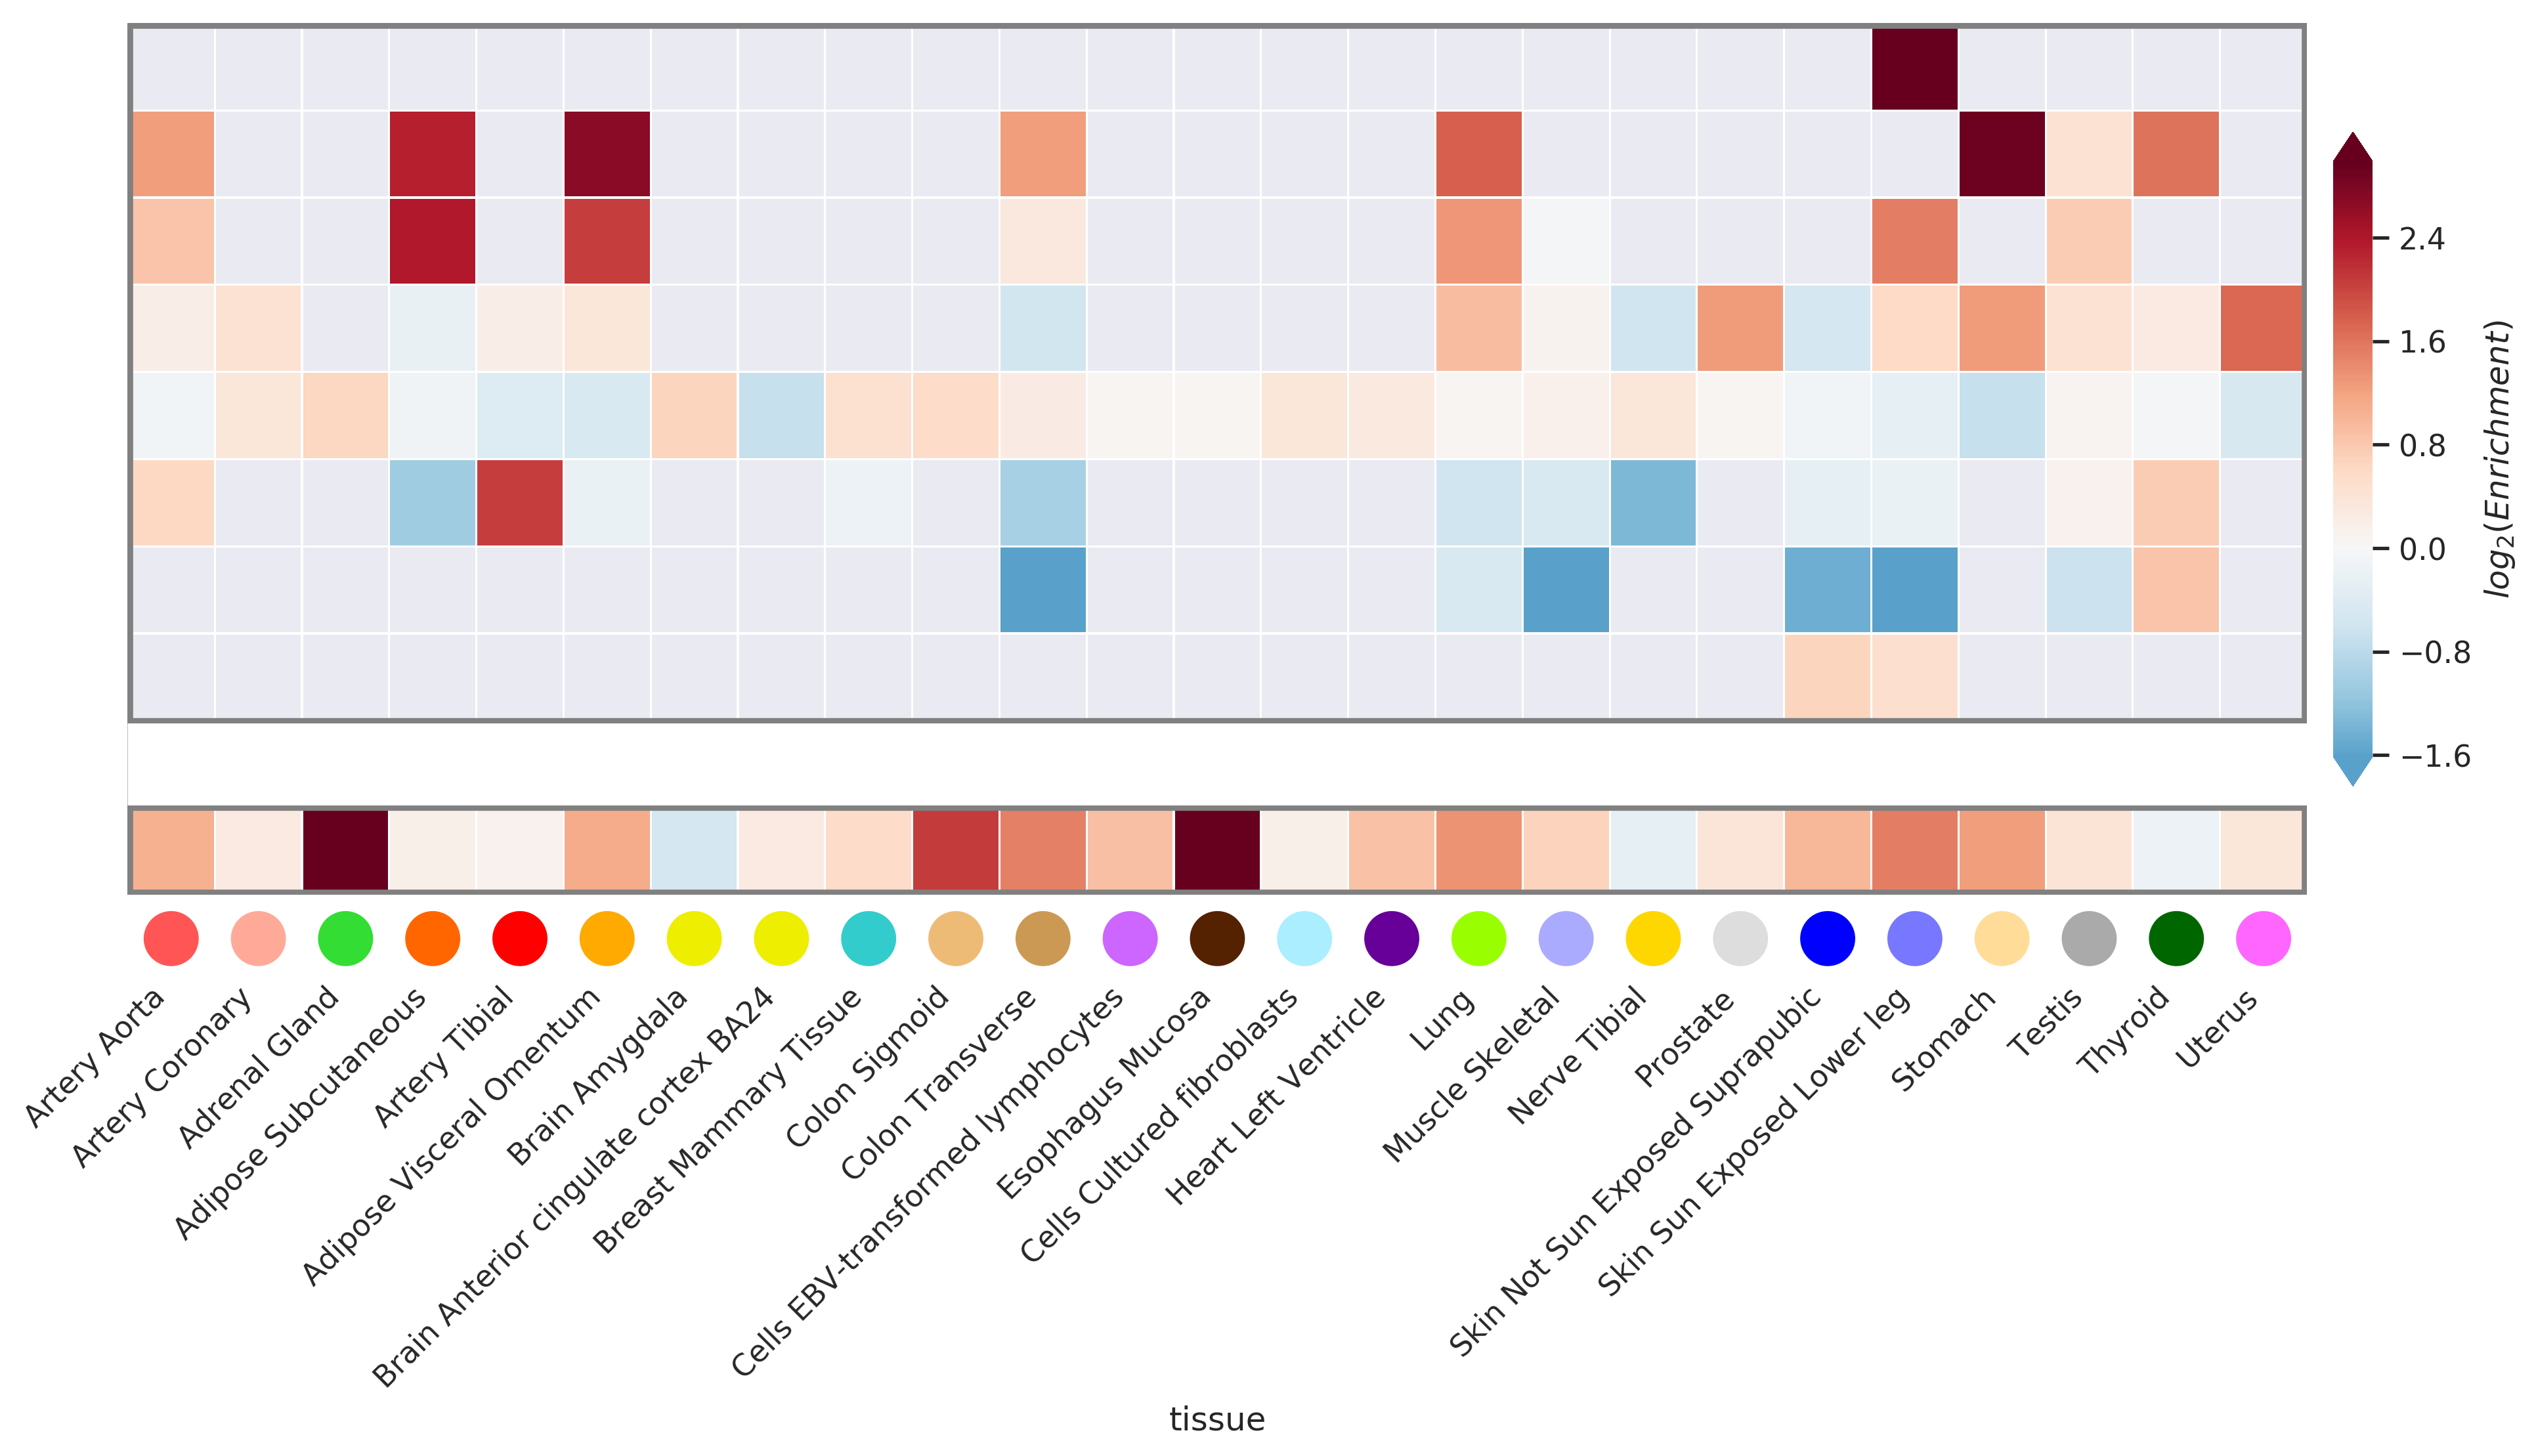

In [102]:
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns; sns.set()

fig = plt.figure(figsize=(17,8), dpi=300)  
ax  = fig.add_subplot(111)
# cbar_ax = fig.add_axes([.905, .3, .05, .3])
cmap = plt.get_cmap("RdBu_r")

mymask = pd.isna(DATA)
mymask.loc["tmp"] = False

h = sns.heatmap(np.log2(DATA),
                cmap=cmap, #"RdBu_r",
                robust=True,
                linewidths=.5,
                center=0.0,
                cbar_kws={'label': '$log_2(Enrichment)$', 'shrink':0.55,
                          'extend':'both',
                          'pad':0.01,
                          'aspect':15},
                ax=ax,
                mask=mymask)

### Use this to change the colorbar ticks and labels
# cbar=plt.colorbar(ax)
# cbar.set_yticklabels(["a","a","a","a","a","a"])
# h.figure.axes[1].set_yticklabels(["-2","-1","0","1","2","3","> 4"])


ylabels = list() # ["3' overlapping ncRNA", "Transcription Factors", "Processed Transcript", "Sense Intronic", "Sense Overlapping", "Protein Coding", "Antisense", "lincRNA", "", "Cis-eQTL Enrichment", "GTEx cis-eQTLs", "GTEx cis-sQTLs"]
for l in DATA.index:
    if l == "tmp":
        ylabels.append("")
    else:
        ylabels.append(l)
        
ylabels = []
ax.set_yticklabels(ylabels, rotation="horizontal")
ax.set_xticklabels(DATA.columns, rotation=90) #, ha='right')

# Countour lines
ax.hlines([ax.get_ylim()[1]]  , *ax.get_xlim(), color='gray', lw=4)
ax.hlines([ax.get_ylim()[0]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-1, ax.get_ylim()[0], color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-1, ax.get_ylim()[1], color='gray', lw=4)

# horizontal middle lines
ax.hlines([ax.get_ylim()[0]-2], *ax.get_xlim(), color='gray', lw=2) # bottom of top rectangle
ax.hlines([ax.get_ylim()[0]-1], *ax.get_xlim(), color='gray', lw=2)  # top of bottom rectangle
# regulate this line 'lw' to cover the empty row with white color
ax.hlines([ax.get_ylim()[0]-1.5]  , *ax.get_xlim(), color='white', lw=30)

my_colors=[tissue_colors[t] for t in DATA.columns]
ax.set_aspect('equal')
for t, X in zip(DATA.columns, ax.get_xticks()):
    ax.add_patch(patches.Circle((X, len(DATA.index)+0.5), radius=.3,
                                 fill=True,clip_on=False, color=tissue_colors[t]))
    
labels = ax.get_xticklabels()
for label in labels:
    label.set_y(label.get_position()[1] - 0.07 )

ax.set_xticklabels([tissue_names[l.get_text()] for l in labels], rotation=45, ha='right')

plt.show()
# plt.savefig("heatmap.png")